<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/CenedDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load files

First of all, let's import the necessary libraries

In [0]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Silence panda's setting with copy warning
pd.options.mode.chained_assignment = None

If it doesn't exist yet, we create a new folder and download the database there as a CSV file

In [0]:
url = 'https://www.dati.lombardia.it/api/views/bbky-sde5/rows.csv?accessType=DOWNLOAD'

if os.path.isdir('/tmp'):
    if os.path.isfile('/tmp/cened.csv'):
      pass
    else:
      urllib.request.urlretrieve(url, '/tmp/cened.csv')
else:
  os.mkdir('/tmp')
  urllib.request.urlretrieve(url, '/tmp/cened.csv')

The file containing the degree day is retrieved from GitHub

In [0]:
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

The database is loaded as a pandas dataframe. Only the required columns are considered.

In [281]:
columns = ['INTERO_EDIFICIO', 'RIQUALIFICAZIONE_ENERGETICA', 'ZONA_CLIMATICA',
           'ANNO_COSTRUZIONE','SUPERF_UTILE_RISCALDATA', 'SUPERF_UTILE_RAFFRESCATA',
           'VOLUME_LORDO_RISCALDATO', 'VOLUME_LORDO_RAFFRESCATO', 'CLASSE_ENERGETICA', 
           'SUPERFICIE_DISPERDENTE', 'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE', 
           'CLASSIFICAZIONE_DPR', 'COMUNE', 'EP_H_ND','EP_GL_NREN','EP_GL_REN', 
           'NUMERO_UNITA_IMMOBILIARI', 'RISTRUTTURAZIONE_IMPORTANTE', 'Y', 
           'CLIMATIZZAZIONE_INVERNALE', 'CI_TIPO_IMPIANTO_1', 'CI_ANNO_INSTALLAZIONE_1',
           'CI_VETTORE_ENERGETICO_1', 'CI_EFFICIENZA_MEDIA', 'CI_POTENZA_NOMINALE_2', 'CI_POTENZA_NOMINALE_1',
           'PFR_TIPO_IMPIANTO_1', 'PFR_ANNO_INSTALLAZIONE_1','PFR_VETTORE_ENERGETICO_1',
           'PFR_EFFICIENZA_MEDIA_1', 'PFR_POTENZA_NOMINALE_1', 'VENTILAZIONE_MECCANICA',
           'PFR_TIPO_IMPIANTO_2', 'PFR_ANNO_INSTALLAZIONE_2','PFR_VETTORE_ENERGETICO_2',
           'PFR_EFFICIENZA_MEDIA_2', 'PFR_POTENZA_NOMINALE_2']

cened = pd.read_csv('/tmp/cened.csv', usecols = columns)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (154,156,161,163) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The rows with NaN values are dropped. Systems won't be considered in this step, instead, they will be filtered later.

In [0]:
for col in ['CI_TIPO_IMPIANTO_1', 'CI_ANNO_INSTALLAZIONE_1','CI_VETTORE_ENERGETICO_1',
           'CI_EFFICIENZA_MEDIA', 'CI_POTENZA_NOMINALE_1','PFR_TIPO_IMPIANTO_1', 
            'PFR_ANNO_INSTALLAZIONE_1','PFR_VETTORE_ENERGETICO_1', 'PFR_EFFICIENZA_MEDIA_1', 
            'PFR_POTENZA_NOMINALE_1', 'VENTILAZIONE_MECCANICA','PFR_TIPO_IMPIANTO_2', 
            'PFR_ANNO_INSTALLAZIONE_2','PFR_VETTORE_ENERGETICO_2', 'PFR_EFFICIENZA_MEDIA_2', 
            'PFR_POTENZA_NOMINALE_2','CI_POTENZA_NOMINALE_2']:
    cened[col].fillna(0, inplace=True)

cened.dropna(inplace = True)

We'll only consider entire, residential buildings.

In [0]:
# Only entire buildings
cened = cened[cened['INTERO_EDIFICIO'] == True]

# Only residential buildings
cened['CLASSIFICAZIONE_DPR'] = cened['CLASSIFICAZIONE_DPR'].str.replace(r'E.1 (1)', 'E.1(1)')
cened = cened[cened['CLASSIFICAZIONE_DPR'] == 'E.1(1)']

Reset index

In [0]:
cened = cened.reset_index(drop=True)

## Corrections

Correct decimal delimiter in floats

In [0]:
for col in ['SUPERF_UTILE_RISCALDATA',
           'SUPERF_UTILE_RAFFRESCATA','VOLUME_LORDO_RISCALDATO','VOLUME_LORDO_RAFFRESCATO','SUPERFICIE_DISPERDENTE',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE','EP_H_ND','EP_GL_NREN','EP_GL_REN']:
    cened[col] = cened[col].astype(str)
    cened[col] = cened[col].str.replace(r',', '')
    cened[col] = cened[col].astype("float")

## Feature creation

Now, we can add the degree days. Several corrections are needed to match the cened database with the dds.

In [0]:
# Add ddh
cened['COMUNE'] = cened['COMUNE'].str.lower()
ddh['comune'] = ddh['comune'].str.lower()
cened['COMUNE'] = cened['COMUNE'].str.replace(r"`",  "'")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"o`",  "o'")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"baranzate",  "bollate")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"borgo virgilio",  "virgilio")
cened['COMUNE'] = cened['COMUNE'].str.replace(r" - ",  "-")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"cassina de pecchi",  "cassina de' pecchi")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"cerano intelvi",  "cerano d'intelvi")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"colverde",  "drezzo")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"cornale e bastida",  "cornale")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"corteolona e genzone",  "corteolona")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"costa serina",  "costa di serina")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"gabbioneta binanuova",  "gabbioneta-binanuova")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"gadesco pieve delmona",  "gadesco-pieve delmona")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"gerre de'caprioli",  "gerre de' caprioli")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"gravedona ed uniti",  "grandola ed uniti")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"la valletta brianza",  "perego")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"lonato del garda",  "lonato")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"maccagno con pino e veddasca",  "maccagno")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"ramponio vernia",  "ramponio verna")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"sermide e felonica",  "sermide")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"toscolano maderno",  "toscolano-maderno")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"tremezzina",  "tremezzo")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"val brembilla",  "brembilla")
cened['COMUNE'] = cened['COMUNE'].str.replace(r"verderio",  "verderio inferiore")

ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cened = cened.merge(ddh, left_on='COMUNE', right_on='comune', how='left')

Add mean height

In [0]:
cened['ALTEZZA_MEDIA'] = cened['VOLUME_LORDO_RISCALDATO']/cened['SUPERF_UTILE_RISCALDATA']

Add period

In [0]:
cened.ANNO_COSTRUZIONE = cened.ANNO_COSTRUZIONE.astype(str)
cened.ANNO_COSTRUZIONE = cened.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened.ANNO_COSTRUZIONE = cened.ANNO_COSTRUZIONE.astype(int)

cened['PERIOD'] = pd.cut(cened.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

In [0]:
cened['A_SOL_EST'] = cened['A_SOL_EST_A_SUP_UTILE']/cened['SUPERF_UTILE_RISCALDATA']

## Filters

In [0]:
cened = cened[cened['EP_H_ND'] < 1000]

In [0]:
cened = cened[cened['SUPERF_UTILE_RISCALDATA'] >= 40]

In [0]:
cened = cened[cened['VOLUME_LORDO_RISCALDATO'] >= 120]

In [0]:
cened = cened[cened['ALTEZZA_MEDIA'] > 2]
cened = cened[cened['ALTEZZA_MEDIA'] < 5]

In [0]:
cened = cened[cened['Y_IE'] <= 6]
cened = cened[cened['Y_IE'] >= 0.03]

In [0]:
cened = cened[cened['CI_POTENZA_NOMINALE_1'] > 0]
cened = cened[cened['CI_POTENZA_NOMINALE_1'] < 200]

In [0]:
cened = cened[cened['CI_EFFICIENZA_MEDIA'] >= 0.2]
cened = cened[cened['CI_EFFICIENZA_MEDIA'] <= 5]

In [0]:
cened = cened[cened['A_SOL_EST_A_SUP_UTILE'] <= 0.5]
cened = cened[cened['A_SOL_EST_A_SUP_UTILE'] > 0]

In [298]:
len(cened)

26328

## Features preparation

Y0 and Y1

In [0]:
cened['Y0'] = cened['Y'].map(lambda x: x.split('(')[0]).astype("category").cat.codes
cened['Y1'] = cened['Y'].map(lambda x: x.split('(')[1].replace(r')', '').replace(r',', '.')).astype(float)

Categorical features

In [0]:
cat_features = ['COMUNE', 'ZONA_CLIMATICA', 'RIQUALIFICAZIONE_ENERGETICA', 
                'RISTRUTTURAZIONE_IMPORTANTE','CLIMATIZZAZIONE_INVERNALE',
                'CI_TIPO_IMPIANTO_1', 'CI_VETTORE_ENERGETICO_1', 'PFR_TIPO_IMPIANTO_1',
                'PFR_VETTORE_ENERGETICO_1', 'PFR_TIPO_IMPIANTO_2', 
                'PFR_VETTORE_ENERGETICO_2', 'VENTILAZIONE_MECCANICA']

for col in cat_features:
  cened[col] = cened[col].astype("category").cat.codes

## ML

In [0]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def split_db(X, y, split = [.8,.1], seed = 0):
    s = [x for x in range(len(y))]
    random.Random(seed).shuffle(s)
    X = X[s]
    y = y[s]
    split1 = int(len(X)*split[0])
    split2 = split1 + int(len(X)*split[1])
    X_train = X[:split1]
    y_train = y[:split1]
    X_val = X[split1:split2]
    y_val = y[split1:split2]
    X_test = X[split2:]
    y_test = y[split2:]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
cened['F1'] = (cened['Y_IE']**2)*cened['SUPERFICIE_DISPERDENTE']
mlcol = ['SUPERF_UTILE_RISCALDATA',
           'VOLUME_LORDO_RISCALDATO',
           'SUPERFICIE_DISPERDENTE', 'dd','PERIOD',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE',
           'ALTEZZA_MEDIA', 'Y1',
             'CLIMATIZZAZIONE_INVERNALE','RIQUALIFICAZIONE_ENERGETICA','RISTRUTTURAZIONE_IMPORTANTE',
             'A_SOL_EST','CI_TIPO_IMPIANTO_1', 'CI_ANNO_INSTALLAZIONE_1','CI_VETTORE_ENERGETICO_1',
           'CI_EFFICIENZA_MEDIA', 'CI_POTENZA_NOMINALE_1','PFR_TIPO_IMPIANTO_1', 'PFR_EFFICIENZA_MEDIA_1','F1',
           'CI_POTENZA_NOMINALE_2'] #, 'NUMERO_UNITA_IMMOBILIARI','Y0'

In [0]:
X = cened[mlcol]
'''
# Normalize features
for col in X.columns:
    if X[col].max() > 1 or X[col].min() < -1:
        std = X[col].std()
        mean = X[col].mean()
        ml_x[col] = ml_x[col].map(lambda x:(x-mean)/std)
X = X.values # This transforms the df into a np array
'''       
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)     


In [0]:
y = cened.EP_H_ND.values

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = split_db(X, y, split = [.8,.1], seed = 42)

In [0]:
K.clear_session()

In [0]:
from keras.constraints import max_norm

# Create NN
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X.shape[1], activation='relu'),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)), #, kernel_constraint=max_norm(2), bias_constraint=max_norm(2)),
        tf.keras.layers.Dense(1, activation='linear')
        ])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), loss = 'mape', metrics=[r2, 'mape', 'mse'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 900, batch_size = 256, verbose=0) #,use_multiprocessing = True

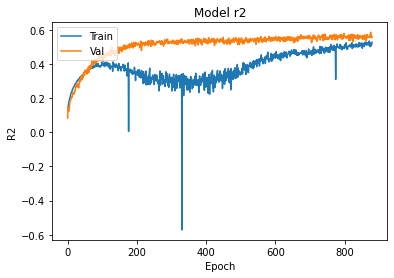

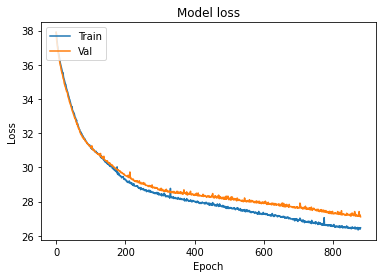

In [310]:
# Plot training & validation accuracy values
plt.plot(history.history['r2'][20:])
plt.plot(history.history['val_r2'][20:])
plt.title('Model r2')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [311]:
pred = model.predict(X_train)
pred = pd.Series([x[0] for x in pred])
y_true = pd.Series([x for x in y_train])

train_df = pd.DataFrame({'true': y_true, 'pred': pred})
train_df['error'] = abs(train_df['true']-train_df['pred'])/train_df['true']*100
#train_df = train_df[train_df['error'] < 100]


print(train_df.error.mean())
r2 = r2_score( train_df['true'], train_df['pred'] )
print(r2)


26.329179092992568
0.5231223426894331


In [312]:
pred = model.predict(X_val)
pred = pd.Series([x[0] for x in pred])
y_true = pd.Series([x for x in y_val])

val_df = pd.DataFrame({'true': y_true, 'pred': pred})
val_df['error'] = abs(val_df['true']-val_df['pred'])/val_df['true']*100
#val_df = val_df[val_df['error'] < 100]

print(val_df.error.mean())
r2 = r2_score( val_df['true'], val_df['pred'] )
print(r2)

27.04377607611565
0.5556419009815525


In [313]:
pred = model.predict(X_test)
pred = pd.Series([x[0] for x in pred])
y_true = pd.Series([x for x in y_test])

test_df = pd.DataFrame({'true': y_true, 'pred': pred})
test_df['error'] = abs(test_df['true']-test_df['pred'])/test_df['true']*100
#test_df = test_df[test_df['error'] < 100]

print(test_df.error.mean())
r2 = r2_score( test_df['true'], test_df['pred'] )
print(r2)

27.056581671030077
0.5770888239580525


In [314]:
'''y_train_log = np.log(y_train)
y_val_log = np.log(y_val)
y_test_log = np.log(y_test)

#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F

#Define training hyperprameters.
batch_size = 32
num_epochs = 100
learning_rate = 0.001
size_hidden= 64

#Calculate some other hyperparameters based on data.  
batch_no = len(X_train) // batch_size  #batches
cols = X_train.shape[1] #Number of columns in input matrix
n_output = 1

#Create the model
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
#print("Executing the model on :",device)

class Net(torch.nn.Module):
    def __init__(self, n_feature, size_hidden, n_output):
        super(Net, self).__init__()
        #self.dropout = torch.nn.Dropout(0.2)
        self.hidden = torch.nn.Linear(cols, size_hidden)   # hidden layer
        self.predict = torch.nn.Linear(size_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(cols, size_hidden, n_output)

#Adam is a specific flavor of gradient decent which is typically better
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) #, weight_decay = 0.04
#optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
#criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss
criterion = torch.nn.SmoothL1Loss()

from sklearn.utils import shuffle
from torch.autograd import Variable

X_train_shuffled, y_train_log_shuffled = shuffle(X_train, y_train_log)

running_loss = 0.0
for epoch in range(num_epochs):
    #Shuffle just mixes up the dataset between epocs
    X_train_shuffled, y_train_log_shuffled = shuffle(X_train_shuffled, y_train_log_shuffled)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train_shuffled[start:end]))
        labels = Variable(torch.FloatTensor(y_train_log_shuffled[start:end]))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print("outputs",outputs)
        #print("outputs",outputs,outputs.shape,"labels",labels, labels.shape)
        loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
    running_loss = 0.0


XV = Variable(torch.FloatTensor(X_train)) 
result = net(XV)
pred = np.exp(result.data[:,0].numpy())

print(r2_score(pred,y_train))
print(mean_absolute_percentage_error(y_train, pred))'''

'y_train_log = np.log(y_train)\ny_val_log = np.log(y_val)\ny_test_log = np.log(y_test)\n\n#Define the model \nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\n#Define training hyperprameters.\nbatch_size = 32\nnum_epochs = 100\nlearning_rate = 0.001\nsize_hidden= 64\n\n#Calculate some other hyperparameters based on data.  \nbatch_no = len(X_train) // batch_size  #batches\ncols = X_train.shape[1] #Number of columns in input matrix\nn_output = 1\n\n#Create the model\n#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n# Assume that we are on a CUDA machine, then this should print a CUDA device:\n#print("Executing the model on :",device)\n\nclass Net(torch.nn.Module):\n    def __init__(self, n_feature, size_hidden, n_output):\n        super(Net, self).__init__()\n        #self.dropout = torch.nn.Dropout(0.2)\n        self.hidden = torch.nn.Linear(cols, size_hidden)   # hidden layer\n        self.predict = torch.nn.Linear(size_hidden, n_output) 

In [315]:
'''XV = Variable(torch.FloatTensor(X_train)) 
result = net(XV)
pred= np.exp(result.data[:,0].numpy())
print(r2_score(pred,y_train))
print(mean_absolute_percentage_error(y_train, pred))'''

'XV = Variable(torch.FloatTensor(X_train)) \nresult = net(XV)\npred= np.exp(result.data[:,0].numpy())\nprint(r2_score(pred,y_train))\nprint(mean_absolute_percentage_error(y_train, pred))'

In [316]:
'''XV = Variable(torch.FloatTensor(X_val)) 
result = net(XV)
pred= np.exp(result.data[:,0].numpy())
print(r2_score(pred,y_val))
print(mean_absolute_percentage_error(y_val, pred))'''

'XV = Variable(torch.FloatTensor(X_val)) \nresult = net(XV)\npred= np.exp(result.data[:,0].numpy())\nprint(r2_score(pred,y_val))\nprint(mean_absolute_percentage_error(y_val, pred))'

In [317]:
'''XV = Variable(torch.FloatTensor(X_test)) 
result = net(XV)
pred = result.data[:,0].numpy()
print(r2_score(pred,y_test))
print(mean_absolute_percentage_error(y_test, pred))'''

'XV = Variable(torch.FloatTensor(X_test)) \nresult = net(XV)\npred = result.data[:,0].numpy()\nprint(r2_score(pred,y_test))\nprint(mean_absolute_percentage_error(y_test, pred))'

In [318]:
test_df

,true,pred,error
0,329.27,376.674988,14.396996
1,79.56,92.387215,16.122693
2,205.44,221.920410,8.022007
3,86.81,69.272720,20.201912
4,215.21,171.610855,20.258884
...,...,...,...
2629,133.55,82.642326,38.118812
2630,167.54,128.653458,23.210303
2631,117.69,123.818245,5.207108
2632,117.48,57.323658,51.205603
